In [1]:
%%capture
%cd ../..

### Opening bid classification

In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn.manifold import TSNE
from bh2vec.vectors_net import VectorsNetNorm
from bh2vec.tools import hand_to_vec, predict_tricks, vec_to_hand, load_vectors_for_hands

In [3]:
sns.set_style('whitegrid')

In [4]:
PATH = 'evaluation/data/openings'

In [5]:
df_train = pd.read_csv(os.path.join(PATH, 'train.csv'), sep=';', index_col=0)
df_test = pd.read_csv(os.path.join(PATH, 'test.csv'), sep=';', index_col=0)

In [6]:
df_train.reset_index(inplace=True, drop=True)
df_train

,PBN,OPENING
0,KQJ4.7.AT87.KQ74,1D
1,QT943.7654.42.A7,PASS
2,AJ7.AQ8754.T4.J5,1H
3,AT987.Q86.KQ4.43,1S
4,J84.T87.6543.QJ9,PASS
...,...,...
995,QT7.AQ9.QT9.T875,PASS
996,AJ3.AJT76.753.K3,1H
997,K972.98.AKJ.A842,1N
998,4.J52.A85.KJT976,PASS


In [7]:
df_test.reset_index(inplace=True, drop=True)
df_test

,PBN,OPENING
0,6.AJT.AJT862.AKQ,1C
1,AKQJ42.A.764.JT6,1S
2,J953.K962.653.A4,PASS
3,AQJ3.KJ.64.KJT85,1C
4,QJ872.984.A4.K75,PASS
...,...,...
208,QJT4.J8.QJ64.743,PASS
209,K93.872.J9763.A5,PASS
210,KJ9.Q54.J94.8732,PASS
211,5.KT.Q984.AKQ976,1C


In [8]:
df_train['OPENING'].value_counts()

PASS    549
1C      127
1H       76
1D       64
1S       64
1N       51
2C       22
2D       14
3C       11
2S        6
3D        4
2H        3
3S        3
2N        3
4H        2
3H        1
Name: OPENING, dtype: int64

In [9]:
df_test['OPENING'].value_counts()

PASS    116
1C       33
1S       18
1D       15
1H       10
2C        7
1N        5
2H        3
2D        2
3D        2
2S        1
3C        1
Name: OPENING, dtype: int64

In [10]:
sorter = ['PASS', '1C', '1D', '1H', '1S', '1N', '2C', '2D', '2H', '2S', '2N', '3C', '3D', '3H', '3S', '4H']

In [11]:
df_train['OPENING'] = df_train['OPENING'].astype("category")
df_train['OPENING'] = df_train['OPENING'].cat.set_categories(sorter)

In [12]:
df_train.sort_values(['OPENING'])

,PBN,OPENING
346,Q72.K5.JT7.A8532,PASS
384,832.AK97.73.J762,PASS
610,K87632.65.T9.T92,PASS
382,JT72.KJ.A7632.42,PASS
381,85.73.KT87.K9874,PASS
...,...,...
801,JT9853.8.T9643.8,3S
172,JT96543.2.4.JT42,3S
129,KQJ5432.932.72.J,3S
316,.KQJT732.9.T9654,4H


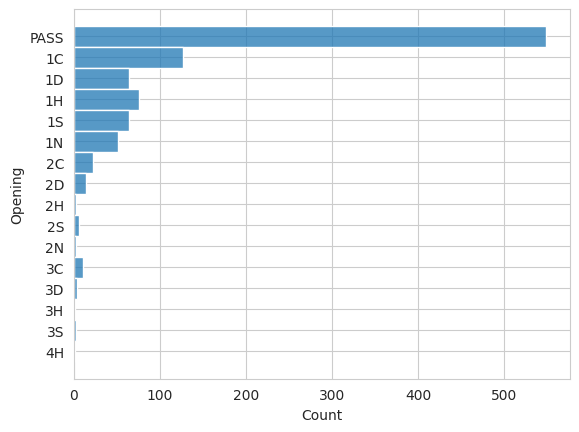

In [13]:
ax = sns.histplot(data=df_train, y="OPENING");
ax.set(ylabel='Opening');

In [14]:
PATH = 'models/model.pth'
net = VectorsNetNorm()
net.load_state_dict(torch.load(PATH))
net.eval()
vec_train = load_vectors_for_hands(net, df_train, hand_col='PBN')
vec_test = load_vectors_for_hands(net, df_test, hand_col='PBN')

In [15]:
vec_cols = ['vec' + str(i) for i in range(8)]
emb_cols = ['emb0', 'emb1']
df_train[vec_cols] = vec_train
df_test[vec_cols] = vec_test

#### T-SNE plot

In [16]:
vec_embedded_train = TSNE(n_components=2, learning_rate='auto', init='random', method='exact',
                          perplexity=10, n_iter=1000, random_state=0).fit_transform(vec_train)

In [17]:
df_train[emb_cols] = vec_embedded_train

In [18]:
df_plot = df_train[df_train['OPENING'].isin(['PASS', '1C', '1D', '1H', '1S', '1N', '2C', '2D', '2H', '2S'])].copy()

In [19]:
df_plot['OPENING'] = df_plot['OPENING'].astype('str')
df_plot['OPENING'] = df_plot['OPENING'].astype("category")
sorter2 = ['PASS', '1C', '1D', '1H', '1S', '1N', '2C', '2D', '2H', '2S']
df_plot['OPENING'] = df_plot['OPENING'].cat.set_categories(sorter2)

In [20]:
new_labels = ['pass', '$1\clubsuit$', '$1\diamondsuit$', '$1\heartsuit$', '$1\spadesuit$', '$1NT$', 
             '$2\clubsuit$', '$2\diamondsuit$', '$2\heartsuit$', '$2\spadesuit$']

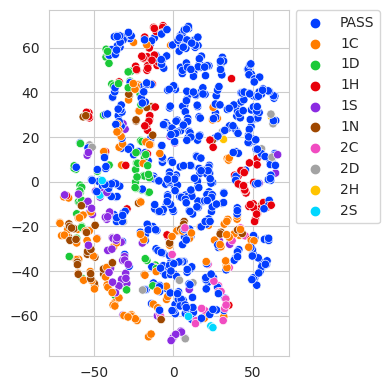

In [21]:
plt.figure(figsize=(4,4))
g = sns.scatterplot(data=df_plot, x='emb0', y='emb1', hue='OPENING', palette="bright");
g.set(xlabel=None);
g.set(ylabel=None);
leg = g.legend()
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
g.legend(loc='upper left', bbox_to_anchor=(1, 1.02047), ncol=1);
plt.tight_layout()
plt.savefig('evaluation/results/figs/openings_tsne.pdf')

#### KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier
import category_encoders as ce

In [23]:
enc_ohe = ce.one_hot.OneHotEncoder(cols=['OPENING'], use_cat_names=True)
X_train = vec_train
y_train = enc_ohe.fit_transform(df_train['OPENING'])

In [24]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [25]:
X_test = vec_test
y_test = enc_ohe.transform(df_test['OPENING'])

In [26]:
neigh.score(X_test, y_test)

0.7136150234741784

#### Controversial openings

In [27]:
def print_nearest(hand, n=5):
    hand_vec = hand_to_vec(net, hand).reshape(1, -1)
    dist, idx = neigh.kneighbors(hand_vec, n_neighbors=n, return_distance=True)
    idx = idx.reshape(-1,).tolist()
    return df_train.iloc[idx][['PBN', 'OPENING']], dist

In [28]:
hands, dist = print_nearest('AT65.KT65.KJ3.65', n=10)
print(hands)
print(dist)

                  PBN OPENING
498  AT98.Q975.K72.95    PASS
3    AT987.Q86.KQ4.43      1S
436  Q87.K983.AQ6.643    PASS
448  Q974.AQ92.QJ2.83      1C
261  Q976.A76.KQ6.J42    PASS
601  Q32.AJ54.K974.J2    PASS
873  AT82.K63.AJT.965      1C
683  A742.Q97.K97.432    PASS
532  AJ2.K854.K65.984    PASS
939  QT85.AT7.K75.865    PASS
[[0.96118854 1.04190205 1.11660639 1.21126058 1.24432534 1.27859615
  1.2874239  1.30464865 1.32016615 1.34509012]]


In [29]:
hands, dist = print_nearest('AK8765.Q76.J65.6', n=10)
print(hands)
print(dist)

                  PBN OPENING
232  AQJT6.J73.9864.J    PASS
530  KQT73.A74.J976.Q      1S
973  KJT97.Q963.A65.9    PASS
31   AQ8743.93.T32.T6      2D
834  AQT54.T82.JT2.64    PASS
290  AT8432.K63.Q98.Q    PASS
866  AQJT63.K8.9732.4      1S
112  AQJ65.K962.84.83    PASS
247  AJT986.764.Q4.73      2D
432  AK8763.752.T8.53    PASS
[[1.16492803 1.16897513 1.32462446 1.36914152 1.40334635 1.44943225
  1.52261668 1.52301339 1.53081    1.56415678]]


In [30]:
hands, dist = print_nearest('AQ765.K5.QJ5.A65', n=10)
print(hands)
print(dist)

                  PBN OPENING
221  AQ94.A86.QJ5.Q95      1N
960  AJT65.A4.K86.A73      1S
124  KQT32.K9.AJ9.KT4      1N
278  KT75.A3.KJ85.K64      1C
831  KT53.A76.QJ94.A3      1C
552  KJ92.A6.AJ832.Q7      1D
706  AJ9764.KQ.K83.A5      1C
154  AT93.K75.AT8.AJ8      1N
891  AJ86.AJ3.J62.AJ4      1N
447  AT53.A65.J85.K83      1C
[[1.09886801 1.14067764 1.20433208 1.31026062 1.5213227  1.55566127
  1.58520459 1.60747039 1.6220881  1.62573649]]


In [31]:
hands, dist = print_nearest('AJT2.KQ.65.QJ654', n=10)
print(hands)
print(dist)

                  PBN OPENING
434  KT72.AK6.3.J8732      1C
921  AJ72.KJT.3.AJ973      2C
227  AJT2.KQ8.74.AQ32      1N
561  AQ5.QJ.852.AJ642      1C
825  Q96.KT.987.KJT76    PASS
901  Q852.AQ.983.Q965    PASS
906  KQJT7.QT.2.AT852      1S
147  QT4.KT7.432.A964    PASS
346  Q72.K5.JT7.A8532    PASS
73   AT52.KJ6.76.9632    PASS
[[1.50571796 1.654123   1.88697389 1.91074389 1.91461425 1.94288356
  1.96925076 2.04483371 2.05930415 2.0719819 ]]


In [32]:
hands, dist = print_nearest('AKT5.AK65.K765.6', n=10)
print(hands)
print(dist)

                  PBN OPENING
327  AQT7.AQ83.QJ97.6      1D
762  KQJ9.A96.A742.62      1N
76   KQ93.A732.AT85.Q      1D
516  AJ65.AQ62.J654.8      1D
725  AKJ9.KQ83.QJ8.A9      1C
383  AKJ54.KQ6.K86.T4      1S
21   KQ87.AJ.AJ862.J8      1D
309  AKJ82.K92.QJT9.5      1S
50   AQ4.A854.KT943.Q      1D
780  AKQ63.AQ973.Q9.4      1C
[[0.86136356 1.55329172 1.61714848 1.7420113  1.75746051 1.76372516
  1.80176843 1.94304813 1.95216343 1.99139033]]
